In [1]:
import numpy as np
import matplotlib.pyplot as plt

from importlib import reload
from cqed.analysis import quantum_jumps as qjmps
reload(qjmps)

# a nice library for hidden markov models, used here to generate some benchmarking data
from hmmlearn import hmm
import xarray as xa

# Generate testing data

In [2]:
def test_data(n_samples, snr, startprob, transition_mtrx, means):
    #fix the random seed to have the same data every time
    np.random.seed(42)

    model = hmm.GaussianHMM(n_components=2, covariance_type="spherical")
    model.startprob_ = startprob
    model.transmat_ = transition_mtrx
    model.means_ = means
    #variance of the blobs
    d = np.sqrt((means[0][0]-means[1][0])**2 + (means[0][1]-means[1][1])**2)
    model.covars_ = ((d/snr)**2., (d/snr)**2.)

    X, Z = model.sample(int(n_samples))
    return X, Z

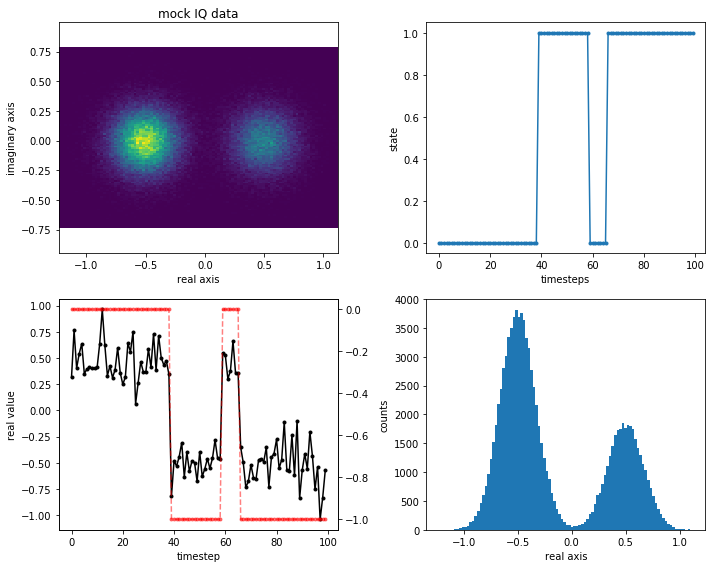

In [122]:
n_samples = 1e5
snr = 6. # defined as distance between means divided by variance, assuming the distance is 1.
dt = 2e-6 

startprob = np.array([0.5, 0.5,])

transition_mtrx = np.array([[0.96, 0.04],
                            [0.02, 0.98]])
#blob means
means = np.array([[0.5, 0.0], 
                  [-0.5, 0.0]])

X, Z = test_data(n_samples, snr, startprob, transition_mtrx, means)

fig, ax = plt.subplots(2, 2, figsize=(10,8))
ax[0,0].hist2d(X[:,0], X[:,1], bins=100)
ax[0,0].axis('equal')
ax[0,0].set_xlabel('real axis')
ax[0,0].set_ylabel('imaginary axis')
ax[0,0].set_title('mock IQ data')

ax[0,1].plot(Z[:100], '.-')
ax[0,1].set_xlabel('timesteps')
ax[0,1].set_ylabel('state')

ax[1,0].plot(X[:100,0], 'k.-')
axz = ax[1,0].twinx()
axz.plot(-1.*Z[:100], 'r.--', alpha=0.5)
ax[1,0].set_xlabel('timestep')
ax[1,0].set_ylabel('real value')

hist = ax[1,1].hist(X[:,0], bins=100)
ax[1,1].set_xlabel('real axis')
ax[1,1].set_ylabel('counts')
fig.tight_layout()

In [123]:
rw = X[:,0] + 1.j*X[:,1]
rw_arr = np.array([ X[:,0], X[:,0], X[:,0], X[:,0], X[:,0], X[:,0], X[:,0]]) + 1.j*np.array([
    X[:,1], X[:,1], X[:,1], X[:,1], X[:,1], X[:,1], X[:,1]
])

# Load your data

In [125]:
# load your trace data either in complex format or as a tuple of (real, imaginary).
# Input data can also be 2d arrays

timestep = 1.
qj = qjmps.QntmJumpTrace(rw_arr, timestep, n_integration=1)

# qj = qjmps.QntmJumpTrace((X[:,0], X[:,1]), data_complex=False)


# How to use the latching filter pipeline

## Usage

In [126]:
################################ 
# perform the entire pipeline: #
################################
# 1) rotate the data for maximum variance
# 2) Histogram the real part of the data and fit a double gaussian
# 3) Run the two point latching-filter algorithm to perform the state assignment
# 4) Histogram the dwell times of the two states and fit an exponential distribution

# For some special cases latching_pipeline has a few kwargs available:
n_bins=101 # number of bins used for the histogram of the real part of the rotated data
dbl_gauss_p0=None # starting parameters for the double gaussian fit
override_gaussfit=False # False: use the parameters found in the 
                        # internal double gauss fit routine for the state assignment algorithm 
                        # True: use the parameters provided through the state_filter_prms kwarg 
                        # for the latching algorithm
state_filter_prms=None  # provide the state filter parameters, 
                        # expects a tuple of ((mu gauss1, mu gauss2), (sigma gauss1, sigma gauss2))
n_sigma_filter=1.5      # threshold for assigning a jump in the latching algorithm is mu - n_sigma_filter * sigma

qj.latching_pipeline(n_bins=n_bins, dbl_gauss_p0=dbl_gauss_p0, override_gaussfit=override_gaussfit, 
                    state_filter_prms=state_filter_prms, n_sigma_filter=n_sigma_filter)

c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:301: RuntimeWarning: divide by zero encountered in log
  x_l = self.hist_dwell_l[0][inds]
c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:311: RuntimeWarning: divide by zero encountered in log
  y_h = log_yh[inds]


C:\Users\lgrunhaupt\AppData\Local\Continuum\anaconda3\envs\qcodes\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


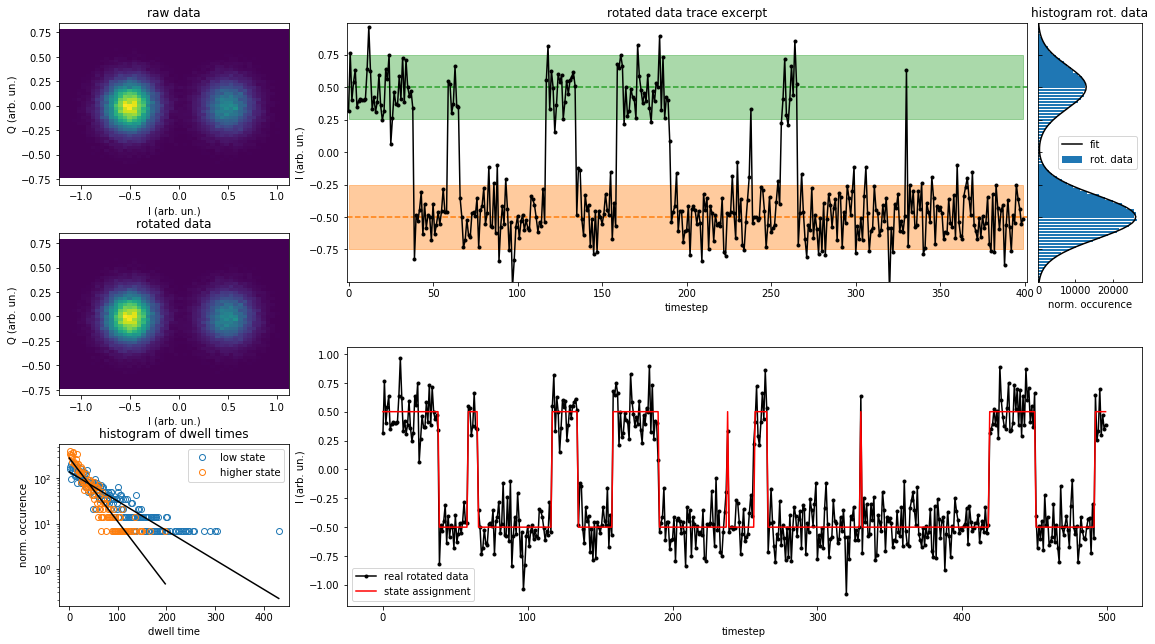

In [127]:
#plot an overview of the analysis
qj.plot_latching_analysis()

## Attributes available after running the pipeline

In [131]:
# raw input dataset:
####
# qj.raw_data

# rotated complex dataset: 
####
# qj.raw_data_rot 

# histogram of real part of rotated data, tuple: (bin axis, norm. counts). 
# Unlike in a standard regular histogram the bin axis is of same length as the number of counts. 
# Bin axis indicates the center point of each bin, i.e. the bin width is bin_axis[1]-bin_axis[0]
####
# qj.raw_hist 

# fit result of the double gaussian routine
# [scaling1, mu1, sigma1, scaling2, mu2, sigma2]
####
# qj.fitresult_gauss

# extracted state vector
###
# qj.state_vec

# list of extracted dwell times
####
# qj.dwell_l
# qj.dwell_h

# histogram of dwell times as tuple (bin axis, norm. counts)
# same approach for the bin axis as above
# available for both states

# qj.hist_dwell_l
# qj.hist_dwell_h

# fitted parameters of fitting a linear function to the log of the dwell time histograms
# uses scipy.optimize.curve_fit internally
# tuple (fitted parameters, cov matrix)
# fitted parameters = [slope, offset]
####
# qj.rate_lh
# qj.rate_hl

# How to use the PSD pipeline

0.020026663078959023 0.040712426233793245


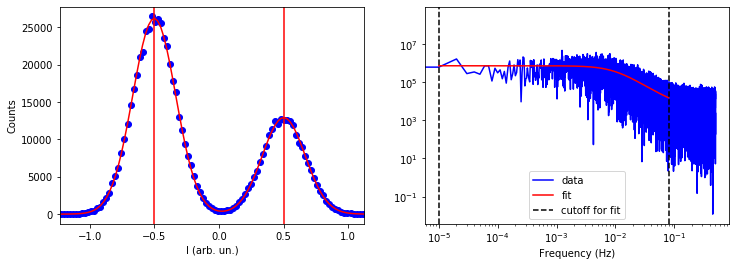

In [135]:
# do the PSD analysis
qj.psd_pipeline()
# plot the fit and processed data
qj.plot_psd_analysis()
# the rates rescaled to seconds are available via these attributes
print(qj.rate_hl_psd, qj.rate_lh_psd)

2008


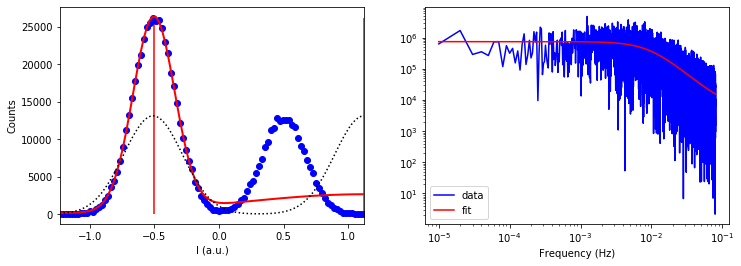

(26.530322535030695, 43.39078816312746)

In [136]:
# compare with Marta's original version
# Still working on figuring out where the discrepancy in rates comes from

qjmps.qj_times_v1(rw_arr, n_bins, n_integration=1)

# How to use the Hidden Markov pipeline

In [137]:
qj.hmm_pipeline()

# Compare all three rates

In [140]:
print('HMM:', qj.rate_hl_hmm, qj.rate_lh_hmm)
print('PSD:', qj.rate_hl_psd, qj.rate_lh_psd)
print('2Pt:', qj.rate_lh[0], qj.rate_hl[0])

HMM: 0.02008994066055404 0.040766573557170935
PSD: 0.020026663078959023 0.040712426233793245
2Pt: 0.014983889180687144 0.03251989178903493


# Benchmarking

Parameters for testing: 50k samples <br>
Asymmetry of rates: 1:1, 1:3, 1:10 <br>
Abs. rates: 1, 0.1, 0.01, 0.001 <br>

In [3]:
def real_rates(snr, startprob, transition_mtrx, means):
        
        model = hmm.GaussianHMM(n_components=2, covariance_type="spherical")
        model.startprob_ = startprob
        model.transmat_ = transition_mtrx
        model.means_ = means
        a = np.linalg.eig(np.array(transition_mtrx)) #calculate the eigenvalues
        tau = -1./np.log(np.abs(np.min(a[0]))) #calculate some characteristic 1/rate TODO: check if this is correct!
        stat = model.get_stationary_distribution() #get the stationary distribution to calculate two times from one

        rate_1 = stat[1]/(stat[1]+stat[0]) / tau
        rate_2 = stat[0]/(stat[0]+stat[1]) / tau
        
        return rate_1, rate_2, stat

## No start parameters given

In [4]:
n_samples = 5e4
snr = 1. # defined as distance between means divided by variance, assuming the distance is 1.
dt = 1. 

startprob = np.array([0.5, 0.5,])
transition_mtrx = np.array([[0.999, 0.001],
                            [0.999, 0.001]])
#blob means
means = np.array([[0.5, 0.0], 
                  [-0.5, 0.0]])

# X, Z = test_data(n_samples, snr, startprob, transition_mtrx, means)

In [5]:
transition_mtrx = np.array([[[0.9, 0.1],[0.1, 0.9]],
                            [[0.9, 0.1],[0.3, 0.7]],
                            [[0.9, 0.1],[0.99, 0.01]],
                            [[0.99, 0.01],[0.01, 0.99]],
                            [[0.99, 0.01],[0.03, 0.97]],
                            [[0.99, 0.01],[0.001, 0.999]]])

rrate1, rrate2, ratio = real_rates(snr, startprob, transition_mtrx[5], means)
print(rrate1, rrate2, ratio)

0.010055406690386319 0.0010055406690386303 [0.09090909 0.90909091]


In [7]:
snrs = np.logspace(np.log10(0.5), np.log10(15), 15)


lat_rates = np.zeros((len(snrs), len(transition_mtrx), 4))
psd_rates = np.zeros((len(snrs), len(transition_mtrx), 4))
hmm_rates = np.zeros((len(snrs), len(transition_mtrx), 2))
insts = np.empty(((len(snrs), len(transition_mtrx))), dtype=object)

for idx, snr in enumerate(snrs):
    
    for idx2, tmat in enumerate(transition_mtrx):
        X, Z = test_data(n_samples, snr, startprob, tmat, means)
        snr_bnchmrk = qjmps.QntmJumpTrace(X[:,0]+1.j*X[:,1], dt)
    
        try:
            snr_bnchmrk.latching_pipeline()
            lat_rates[idx, idx2, :] = snr_bnchmrk.rate_lh[0], snr_bnchmrk.rate_lh_err[0], snr_bnchmrk.rate_hl[0], snr_bnchmrk.rate_hl_err[0]
        except (TypeError, ValueError):
            lat_rates[idx, idx2, :] = np.nan, np.nan, np.nan, np.nan

        snr_bnchmrk.psd_pipeline()
        snr_bnchmrk.hmm_pipeline()

        psd_rates[idx, idx2, :] = snr_bnchmrk.rate_lh_psd, snr_bnchmrk.rate_lh_psd_err, snr_bnchmrk.rate_hl_psd, snr_bnchmrk.rate_lh_psd_err
        hmm_rates[idx, idx2, :] = snr_bnchmrk.rate_lh_hmm, snr_bnchmrk.rate_hl_hmm
        insts[idx, idx2] = snr_bnchmrk

C:\Users\lgrunhaupt\AppData\Local\Continuum\anaconda3\envs\qcodes\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\lgrunhaupt\AppData\Local\Continuum\anaconda3\envs\qcodes\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\lgrunhaupt\AppData\Local\Continuum\anaconda3\envs\qcodes\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\lgrunhaupt\AppData\Local\Continuum\anaconda3\envs\qcodes\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\lgrunhaupt\AppData\Local\Continuum\anaconda3\envs\qcodes\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the pa

In [9]:
latching = xa.merge([xa.DataArray(lat_rates[:,:,0], name='rate_lh', 
                                  coords={'SNR': snrs, 'Transitionmatr': np.arange(1,7,1)}, 
                                  dims=['SNR', 'Transitionmatr']), 
                     xa.DataArray(lat_rates[:,:,1], name='rate_lh_err', 
                                  coords={'SNR': snrs, 'Transitionmatr': np.arange(1,7,1)}, 
                                  dims=['SNR', 'Transitionmatr']),
                     xa.DataArray(lat_rates[:,:,2], name='rate_hl', 
                                  coords={'SNR': snrs, 'Transitionmatr': np.arange(1,7,1)}, 
                                  dims=['SNR', 'Transitionmatr']),
                     xa.DataArray(lat_rates[:,:,0], name='rate_hl_err', 
                                  coords={'SNR': snrs, 'Transitionmatr': np.arange(1,7,1)}, 
                                  dims=['SNR', 'Transitionmatr'])])

In [10]:
psd = xa.merge([xa.DataArray(psd_rates[:,:,0], name='rate_lh', 
                                  coords={'SNR': snrs, 'Transitionmatr': np.arange(1,7,1)}, 
                                  dims=['SNR', 'Transitionmatr']), 
                     xa.DataArray(psd_rates[:,:,1], name='rate_lh_err', 
                                  coords={'SNR': snrs, 'Transitionmatr': np.arange(1,7,1)}, 
                                  dims=['SNR', 'Transitionmatr']),
                     xa.DataArray(psd_rates[:,:,2], name='rate_hl', 
                                  coords={'SNR': snrs, 'Transitionmatr': np.arange(1,7,1)}, 
                                  dims=['SNR', 'Transitionmatr']),
                     xa.DataArray(psd_rates[:,:,0], name='rate_hl_err', 
                                  coords={'SNR': snrs, 'Transitionmatr': np.arange(1,7,1)}, 
                                  dims=['SNR', 'Transitionmatr'])])

In [11]:
hmms = xa.merge([xa.DataArray(hmm_rates[:,:,0], name='rate_lh', 
                                  coords={'SNR': snrs, 'Transitionmatr': np.arange(1,7,1)}, 
                                  dims=['SNR', 'Transitionmatr']), 
                     xa.DataArray(lat_rates[:,:,1], name='rate_hl', 
                                  coords={'SNR': snrs, 'Transitionmatr': np.arange(1,7,1)}, 
                                  dims=['SNR', 'Transitionmatr'])])

### Plot rates of different approaches

Generated rates: 0.112, 0.112 | State ratios: 0.500:0.500


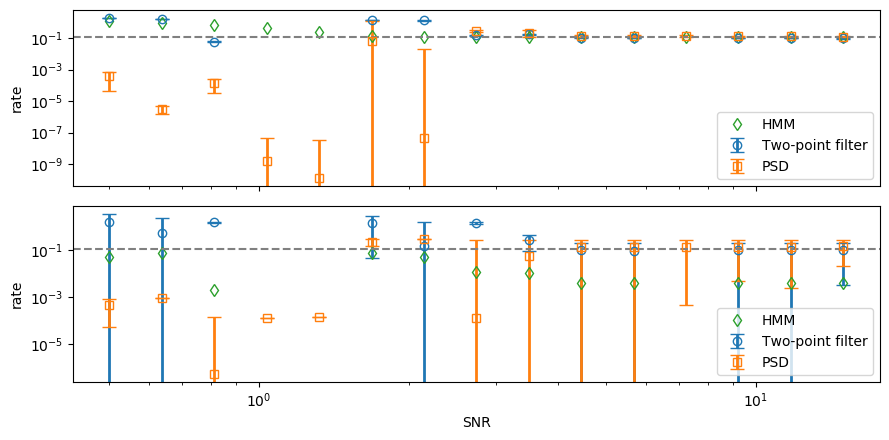

In [110]:
fig, ax = plt.subplots(2,1, figsize=(9,4.5), sharex=True)

transmat_idx = 0
rrate1, rrate2, ratio = real_rates(snr, startprob, transition_mtrx[transmat_idx], means)

ax[0].errorbar(snrs, latching.rate_lh.isel(Transitionmatr=transmat_idx), 
               yerr=latching.rate_lh_err.isel(Transitionmatr=transmat_idx), 
               label='Two-point filter', marker='o', mfc='none', lw=0, capsize=5, elinewidth=2)
ax[0].errorbar(snrs, psd.rate_lh.isel(Transitionmatr=transmat_idx), 
               yerr=psd.rate_lh_err.isel(Transitionmatr=transmat_idx), 
               label='PSD', marker='s', mfc='none', lw=0, capsize=5, elinewidth=2)
ax[0].plot(snrs, hmms.rate_lh.isel(Transitionmatr=transmat_idx), marker='d', label='HMM', lw=0, mfc='none')
ax[0].axhline(rrate1, color='grey', ls='dashed')

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend()
ax[0].set_ylabel('rate')
ax[0].set_ylim(1e-6, 5)

ax[1].errorbar(snrs, latching.rate_hl.isel(Transitionmatr=transmat_idx), 
               yerr=latching.rate_hl_err.isel(Transitionmatr=transmat_idx), 
               label='Two-point filter', marker='o', mfc='none', lw=0, capsize=5, elinewidth=2)
ax[1].errorbar(snrs, psd.rate_hl.isel(Transitionmatr=transmat_idx), 
               yerr=psd.rate_hl_err.isel(Transitionmatr=transmat_idx), 
               label='PSD', marker='s', mfc='none', lw=0, capsize=5, elinewidth=2)
ax[1].plot(snrs, hmms.rate_hl.isel(Transitionmatr=transmat_idx), marker='d', label='HMM', lw=0, mfc='none')
ax[1].axhline(rrate2, color='grey', ls='dashed')

ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend()
ax[1].set_xlabel('SNR')
ax[1].set_ylabel('rate')
ax[1].set_ylim(ax[0].get_ylim())
fig.tight_layout()
print(f'Generated rates: {rrate1:.3f}, {rrate2:.3f} | State ratios: {ratio[0]:.3f}:{ratio[1]:.3f}')

### Plot individual analysis results

In [ ]:
transmat_idx = 0
snr_indx = 14 #1.3: 4, 2.7: 7, 5.7: 10, 
print(snrs[snr_indx])
insts[snr_indx, transmat_idx].plot_latching_analysis()

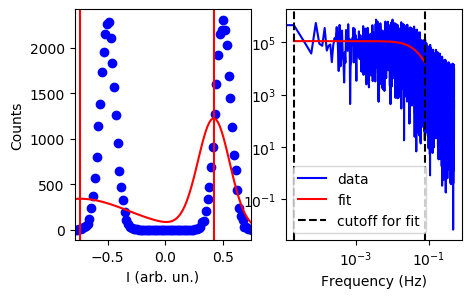

In [115]:
insts[snr_indx, transmat_idx].plot_psd_analysis(figsize=(5, 3))

In [109]:
# Looking at gauss-fit results
insts[snr_indx, transmat_idx].fitresult_gauss.params

name,value,standard error,relative error,initial value,min,max,vary
c1,468.411590,0.55053230,(0.12%),445.9542461197064,0.00000000,2229.77123,True
c2,451.780990,0.60728746,(0.13%),445.9542461197064,0.00000000,2229.77123,True
mu1,0.50024273,1.4789e-04,(0.03%),0.49138391032090034,-0.96570048,0.89045798,True
mu2,-0.50068881,2.0557e-04,(0.04%),0.8904579786565023,-0.96570048,0.89045798,True
sig1,0.10897308,1.4789e-04,(0.14%),0.2060335887686131,0.01030168,4.12067178,True
sig2,0.10444306,1.8093e-04,(0.17%),0.2060335887686131,0.01030168,4.12067178,True


## Start parameters for Gaussian fit given to pipelines

In [52]:
snrs = np.logspace(np.log10(0.5), np.log10(15), 15)


lat_rates = np.zeros((len(snrs), len(transition_mtrx), 4))
psd_rates = np.zeros((len(snrs), len(transition_mtrx), 4))
hmm_rates = np.zeros((len(snrs), len(transition_mtrx), 2))
insts_p0 = np.empty(((len(snrs), len(transition_mtrx))), dtype=object)

for idx, snr in enumerate(snrs):
    
    for idx2, tmat in enumerate(transition_mtrx):
        X, Z = test_data(n_samples, snr, startprob, tmat, means)
        snr_bnchmrk = qjmps.QntmJumpTrace(X[:,0]+1.j*X[:,1], dt)
    
        try:
            snr_bnchmrk.latching_pipeline(dbl_gauss_p0=[200, -0.5, 1./snr**2, 200, 0.5, 1./snr**2])
            lat_rates[idx, idx2, :] = snr_bnchmrk.rate_lh[0], snr_bnchmrk.rate_lh_err[0], snr_bnchmrk.rate_hl[0], snr_bnchmrk.rate_hl_err[0]
        except (TypeError, ValueError):
            lat_rates[idx, idx2, :] = np.nan, np.nan, np.nan, np.nan
            
        try:
            snr_bnchmrk.psd_pipeline(dbl_gauss_p0=[200, -0.5, 1./snr**2, 200, 0.5, 1./snr**2])
            psd_rates[idx, idx2, :] = snr_bnchmrk.rate_lh_psd, snr_bnchmrk.rate_lh_psd_err, snr_bnchmrk.rate_hl_psd, snr_bnchmrk.rate_lh_psd_err
        except TypeError:
            psd_rates[idx, idx2, :] = np.nan, np.nan, np.nan, np.nan    
            
        snr_bnchmrk.hmm_pipeline()
        hmm_rates[idx, idx2, :] = snr_bnchmrk.rate_lh_hmm, snr_bnchmrk.rate_hl_hmm
        insts_p0[idx, idx2] = snr_bnchmrk

c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:317: RuntimeWarning: divide by zero encountered in log
  log_yl = np.log(self.hist_dwell_l[1])
c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:326: RuntimeWarning: divide by zero encountered in log
  log_yh = np.log(self.hist_dwell_h[1])
c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:317: RuntimeWarning: divide by zero encountered in log
  log_yl = np.log(self.hist_dwell_l[1])
c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:326: RuntimeWarning: divide by zero encountered in log
  log_yh = np.log(self.hist_dwell_h[1])
c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:317: RuntimeWarning: divide by zero encountered in log
  log_yl = np.log(self.hist_dwell_l[1])
c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:326: RuntimeWarning: divide by zero encountered in log
  

c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:317: RuntimeWarning: divide by zero encountered in log
  log_yl = np.log(self.hist_dwell_l[1])
c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:317: RuntimeWarning: divide by zero encountered in log
  log_yl = np.log(self.hist_dwell_l[1])
c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:326: RuntimeWarning: divide by zero encountered in log
  log_yh = np.log(self.hist_dwell_h[1])
c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:317: RuntimeWarning: divide by zero encountered in log
  log_yl = np.log(self.hist_dwell_l[1])
c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:326: RuntimeWarning: divide by zero encountered in log
  log_yh = np.log(self.hist_dwell_h[1])
c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:317: RuntimeWarning: divide by zero encountered in log
  

c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:317: RuntimeWarning: divide by zero encountered in log
  log_yl = np.log(self.hist_dwell_l[1])
c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:326: RuntimeWarning: divide by zero encountered in log
  log_yh = np.log(self.hist_dwell_h[1])
c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:317: RuntimeWarning: divide by zero encountered in log
  log_yl = np.log(self.hist_dwell_l[1])
c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:326: RuntimeWarning: divide by zero encountered in log
  log_yh = np.log(self.hist_dwell_h[1])
c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:317: RuntimeWarning: divide by zero encountered in log
  log_yl = np.log(self.hist_dwell_l[1])
c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:326: RuntimeWarning: divide by zero encountered in log
  

c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:317: RuntimeWarning: divide by zero encountered in log
  log_yl = np.log(self.hist_dwell_l[1])
c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:326: RuntimeWarning: divide by zero encountered in log
  log_yh = np.log(self.hist_dwell_h[1])
c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:317: RuntimeWarning: divide by zero encountered in log
  log_yl = np.log(self.hist_dwell_l[1])
c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:326: RuntimeWarning: divide by zero encountered in log
  log_yh = np.log(self.hist_dwell_h[1])
c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:317: RuntimeWarning: divide by zero encountered in log
  log_yl = np.log(self.hist_dwell_l[1])
c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:326: RuntimeWarning: divide by zero encountered in log
  

In [53]:
rates1 = np.zeros((len(snrs), len(transition_mtrx)))
rates2 = np.zeros((len(snrs), len(transition_mtrx)))
for idx, snr in enumerate(snrs):   
    for idx2, tmat in enumerate(transition_mtrx):
        rates1[idx,idx2], rates2[idx,idx2], ratio = real_rates(snr, startprob, tmat, means)

In [54]:
rates = xa.merge([xa.DataArray(rates1, name='rate_lh', 
                                  coords={'SNR': snrs, 'Transitionmatr': np.arange(1,7,1)}, 
                                  dims=['SNR', 'Transitionmatr']),
                 xa.DataArray(rates2, name='rate_hl', 
                                  coords={'SNR': snrs, 'Transitionmatr': np.arange(1,7,1)}, 
                                  dims=['SNR', 'Transitionmatr'])])

In [55]:
latching_p0 = xa.merge([xa.DataArray(lat_rates[:,:,0], name='rate_lh', 
                                  coords={'SNR': snrs, 'Transitionmatr': np.arange(1,7,1)}, 
                                  dims=['SNR', 'Transitionmatr']), 
                     xa.DataArray(lat_rates[:,:,1], name='rate_lh_err', 
                                  coords={'SNR': snrs, 'Transitionmatr': np.arange(1,7,1)}, 
                                  dims=['SNR', 'Transitionmatr']),
                     xa.DataArray(lat_rates[:,:,2], name='rate_hl', 
                                  coords={'SNR': snrs, 'Transitionmatr': np.arange(1,7,1)}, 
                                  dims=['SNR', 'Transitionmatr']),
                     xa.DataArray(lat_rates[:,:,0], name='rate_hl_err', 
                                  coords={'SNR': snrs, 'Transitionmatr': np.arange(1,7,1)}, 
                                  dims=['SNR', 'Transitionmatr'])])

In [56]:
psd_p0 = xa.merge([xa.DataArray(psd_rates[:,:,0], name='rate_lh', 
                                  coords={'SNR': snrs, 'Transitionmatr': np.arange(1,7,1)}, 
                                  dims=['SNR', 'Transitionmatr']), 
                     xa.DataArray(psd_rates[:,:,1], name='rate_lh_err', 
                                  coords={'SNR': snrs, 'Transitionmatr': np.arange(1,7,1)}, 
                                  dims=['SNR', 'Transitionmatr']),
                     xa.DataArray(psd_rates[:,:,2], name='rate_hl', 
                                  coords={'SNR': snrs, 'Transitionmatr': np.arange(1,7,1)}, 
                                  dims=['SNR', 'Transitionmatr']),
                     xa.DataArray(psd_rates[:,:,0], name='rate_hl_err', 
                                  coords={'SNR': snrs, 'Transitionmatr': np.arange(1,7,1)}, 
                                  dims=['SNR', 'Transitionmatr'])])

In [57]:
hmms_p0 = xa.merge([xa.DataArray(hmm_rates[:,:,0], name='rate_lh', 
                                  coords={'SNR': snrs, 'Transitionmatr': np.arange(1,7,1)}, 
                                  dims=['SNR', 'Transitionmatr']), 
                     xa.DataArray(lat_rates[:,:,1], name='rate_hl', 
                                  coords={'SNR': snrs, 'Transitionmatr': np.arange(1,7,1)}, 
                                  dims=['SNR', 'Transitionmatr'])])

### Plot rates of different approaches

In [69]:
transmat_idx = 5
rrate1, rrate2, ratio = real_rates(snr, startprob, transition_mtrx[transmat_idx], means)

fig, ax = plt.subplots(2,1, figsize=(9,4.5), sharex=True)
ax[0].errorbar(snrs, latching_p0.rate_lh.isel(Transitionmatr=transmat_idx), 
               yerr=latching_p0.rate_lh_err.isel(Transitionmatr=transmat_idx), 
               label='Two-point filter', marker='o', mfc='none', lw=0, capsize=5, elinewidth=2)
ax[0].errorbar(snrs, psd_p0.rate_lh.isel(Transitionmatr=transmat_idx), 
               yerr=psd_p0.rate_lh_err.isel(Transitionmatr=transmat_idx), 
               label='PSD', marker='s', mfc='none', lw=0, capsize=5, elinewidth=2)
ax[0].plot(snrs, hmms_p0.rate_lh.isel(Transitionmatr=transmat_idx), marker='d', label='HMM', lw=0, mfc='none')
ax[0].axhline(rrate1, color='grey', ls='dashed')

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend()
ax[0].set_ylabel('rate')
ax[0].set_ylim(1e-6, 10)

ax[1].errorbar(snrs, latching_p0.rate_hl.isel(Transitionmatr=transmat_idx), 
               yerr=latching_p0.rate_hl_err.isel(Transitionmatr=transmat_idx), 
               label='Two-point filter', marker='o', mfc='none', lw=0, capsize=5, elinewidth=2)
ax[1].errorbar(snrs, psd_p0.rate_hl.isel(Transitionmatr=transmat_idx), 
               yerr=psd_p0.rate_hl_err.isel(Transitionmatr=transmat_idx), 
               label='PSD', marker='s', mfc='none', lw=0, capsize=5, elinewidth=2)
ax[1].plot(snrs, hmms_p0.rate_hl.isel(Transitionmatr=transmat_idx), marker='d', label='HMM', lw=0, mfc='none')
# ax[1].plot(snrs, hmms_p0.rate_lh.isel(Transitionmatr=transmat_idx), marker='d', label='HMM', lw=0, mfc='none')
ax[1].axhline(rrate2, color='grey', ls='dashed')

ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend()
ax[1].set_xlabel('SNR')
ax[1].set_ylabel('rate')
ax[1].set_ylim(ax[0].get_ylim())
fig.tight_layout()
print(f'Generated rates: {rrate1:.3f}, {rrate2:.3f} | State ratios: {ratio[0]:.3f}:{ratio[1]:.3f}')

Generated rates: 0.010, 0.001 | State ratios: 0.091:0.909


### Plot individual analysis result

5.676185956352383


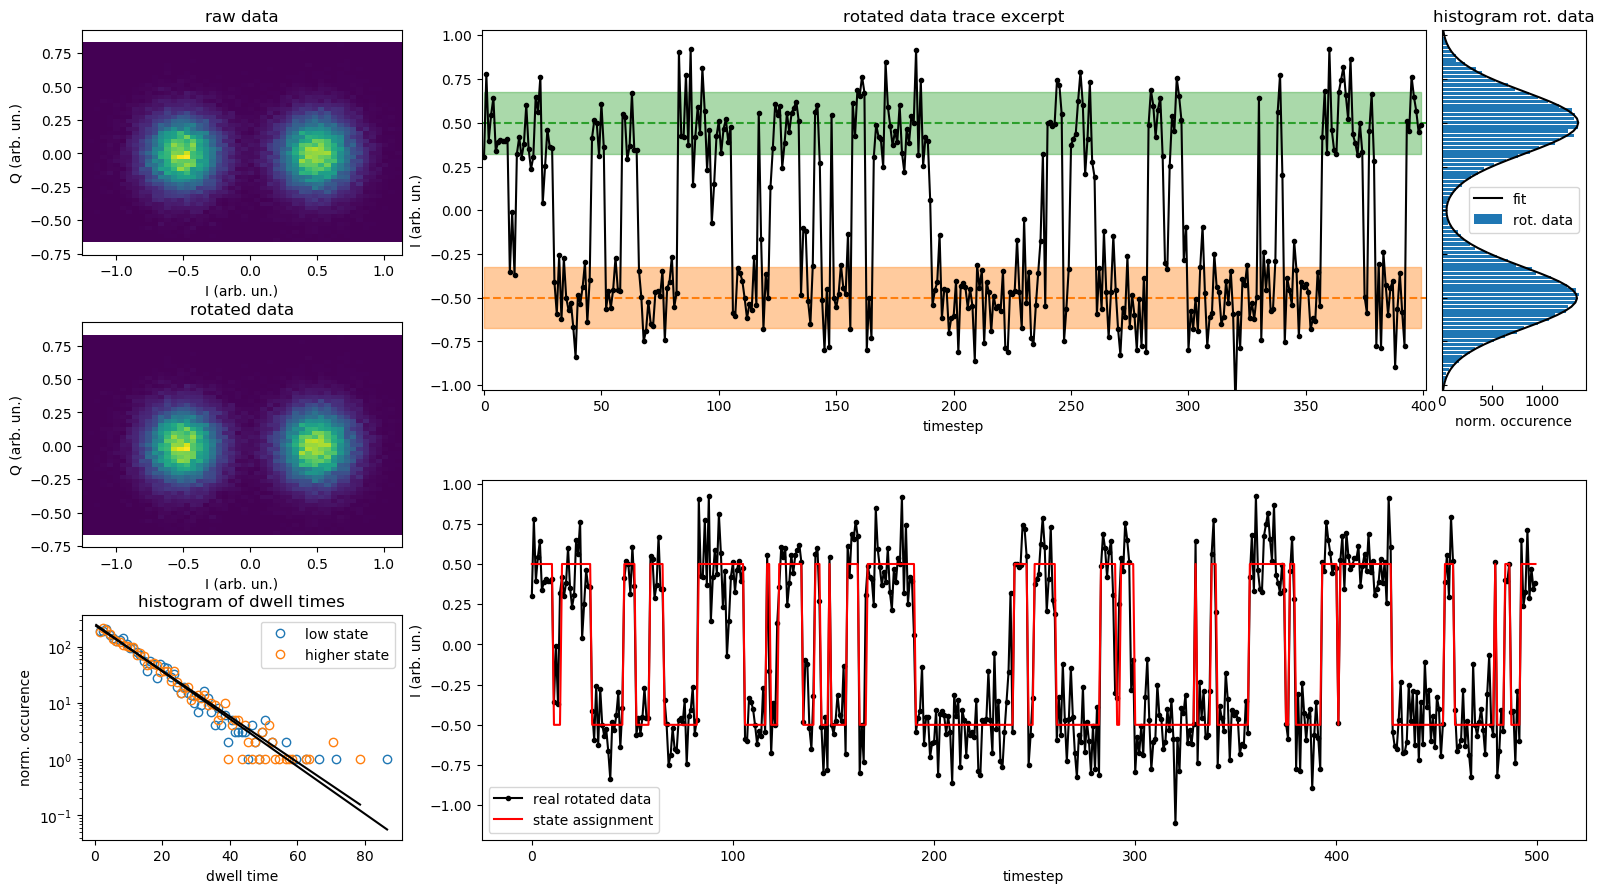

In [207]:
transmat_idx = 0
snr_indx = 10 #1.3: 4, 2.7: 7, 5.7: 10, 
print(snrs[snr_indx])
insts_p0[snr_indx, transmat_idx].plot_latching_analysis()

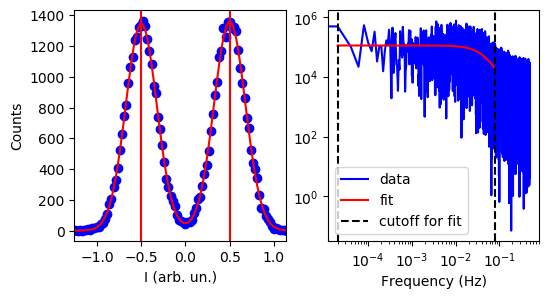

In [208]:
insts_p0[snr_indx, transmat_idx].plot_psd_analysis(figsize=(6, 3))

### Compare errors and difference from real rate

In [22]:
import matplotlib.colors as colors

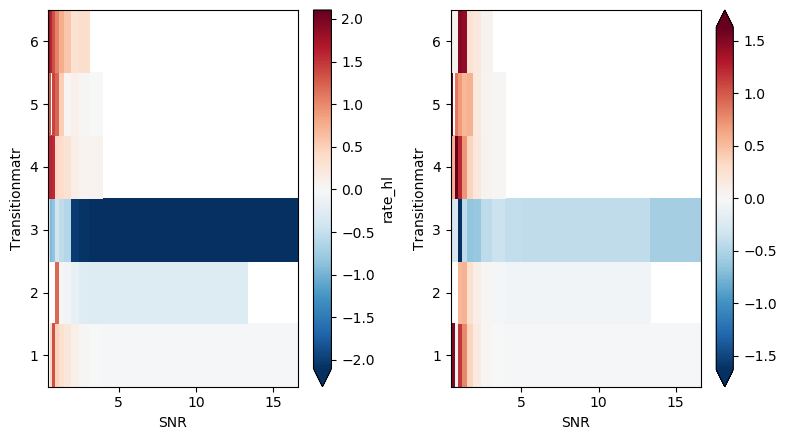

In [202]:
fig, axs = plt.subplots(1,2, figsize=(8,4.5))
(latching_p0.rate_hl - rates.rate_hl).plot(x='SNR', ax=axs[0], robust=True)
(latching_p0.rate_lh - rates.rate_hl).plot(x='SNR', ax=axs[1], robust=True)
fig.tight_layout()

#### Extracted rate - real rate in log-scale

In [71]:
fig, axs = plt.subplots(1,2, figsize=(8,3.5))
np.abs((psd_p0.rate_hl - rates.rate_hl)).plot(x='SNR', ax=axs[0], norm=colors.LogNorm(), 
                                              cbar_kwargs={"label": 'abs(rate PSD - real rate)'})
np.abs((psd_p0.rate_lh - rates.rate_lh)).plot(x='SNR', ax=axs[1], norm=colors.LogNorm(),
                                             cbar_kwargs={"label": 'abs(rate PSD - real rate)'})
fig.tight_layout()

In [33]:
fig, axs = plt.subplots(1,2, figsize=(8,3.5))
np.abs((latching_p0.rate_hl - rates.rate_hl)).plot(x='SNR', ax=axs[0], norm=colors.LogNorm(),
                                                  cbar_kwargs={"label": 'abs(rate 2Pt - real rate)'})
np.abs((latching_p0.rate_lh - rates.rate_lh)).plot(x='SNR', ax=axs[1], norm=colors.LogNorm(),
                                                  cbar_kwargs={"label": 'abs(rate 2Pt - real rate)'})
fig.tight_layout()

In [72]:
fig, axs = plt.subplots(1,2, figsize=(8,3.5))
np.abs((hmms_p0.rate_hl - rates.rate_hl)).plot(x='SNR', ax=axs[0], norm=colors.LogNorm(),
                                              cbar_kwargs={"label": 'abs(rate hmm - real rate)'})
np.abs((hmms_p0.rate_lh - rates.rate_lh)).plot(x='SNR', ax=axs[1], norm=colors.LogNorm(),
                                              cbar_kwargs={"label": 'abs(rate hmm - real rate)'})
fig.tight_layout()

In [92]:
np.abs((psd_p0.rate_hl_err 
        - psd_p0.rate_lh_err)).plot(x='SNR', norm=colors.LogNorm(), robust=True,  
                                                   cbar_kwargs={"label": 'abs(err. PSD rate 1 - err. PSD rate 2)'})

In [93]:
np.abs((latching_p0.rate_hl_err
        - latching_p0.rate_lh_err)).plot(x='SNR', norm=colors.LogNorm(), robust=False,  
                                                   cbar_kwargs={"label": 'abs(err. 2Pt rate 1 - err. 2Pt rate 2)'})

## Latching filter

## Influence of n_sigma_filter for constant SNR = 15

In [33]:
snr = 15.
x, z = test_data(n_samples, snr, startprob, transition_mtrx, means)

rate_l = []
rate_h = []

bm_sigs = [0.1, 0.2, 0.5, 1, 2, 3, 4, 5, 6, 7]

for n_sg in bm_sigs:
    qj = qjmps.QntmJumpTrace(x[:,0]+1.j*x[:,1])
    qj.latching_pipeline(n_sigma_filter=n_sg)
#     qj.plot_analysis()
    rate_l.append(qj.rate_lh[0][0])
    rate_h.append(qj.rate_hl[0][0])

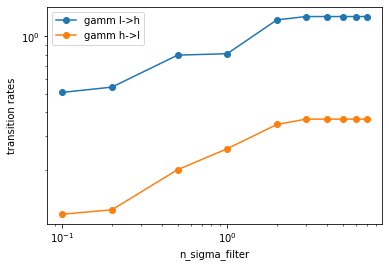

In [36]:
plt.plot(bm_sigs, rate_l, 'o-', label='gamm l->h')
plt.plot(bm_sigs, rate_h, 'o-', label='gamm h->l')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('n_sigma_filter')
plt.ylabel('transition rates')
plt.legend()